In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd, numpy as np
from numpy.testing import assert_allclose
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from textblob import TextBlob
#from spacy_langdetect import LanguageDetector
#from langdetect import detect
#import swifter
import datetime
import spacy
import os
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential 
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPooling1D,Conv1D,SpatialDropout1D,Concatenate
from keras.models import Model
from keras.layers import CuDNNGRU,CuDNNLSTM
from keras.layers import GlobalAveragePooling1D
from tensorflow.keras import layers
from keras.layers import Flatten
from tensorflow.keras import regularizers
from keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

import tensorflow as tf

from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from tensorflow.keras import optimizers

%load_ext tensorboard

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd  /content/drive/MyDrive/Kaggle

/content/drive/MyDrive/Kaggle


In [4]:
#loading preprocssed data
data = pd.read_csv('train_que_preprocessed.csv')
train_df = pd.read_csv('train.csv')
Y = train_df['target']
data.head(10)

,question,question_len,num_of_words,num_of_sentences,unique_words,stop_words
0,how did quebec nationalists see their province...,72,13,1,13,6
1,do you have an adopted dog how would you encou...,81,16,1,15,8
2,why does velocity affect time does velocity af...,67,10,2,8,1
3,how did otto von guericke used the magdeburg h...,57,9,1,9,2
4,can i convert montra helicon d to a mountain b...,77,15,1,15,5
5,is gaza slowly becoming auschwitz dachau or tr...,72,10,1,10,2
6,why does quora automatically ban conservative ...,113,18,1,17,9
7,is it crazy if i wash or wipe my groceries off...,69,14,2,14,6
8,is there such a thing as dressing moderately a...,102,18,1,17,11
9,is it just me or have you ever been in this ph...,246,44,2,39,23


In [5]:
del train_df
gc.collect()

86

In [6]:
%%time

#removing special chars
def nospecial(text):
	text = re.sub("[^a-zA-Z\s]+", "",text)
	return text

data['question'] = data['question'].apply(str).apply(nospecial)

# checking no.of data points in each class
print('No.of Datapoints in class-0 before split:',Y.value_counts()[0]) 
print('No.of Datapoints in class-1 before split:',Y.value_counts()[1])

#spliting data into train,cv and test sets
X_train, X_cv, y_train, y_cv = train_test_split(data, Y, test_size=0.1,stratify = Y)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1,stratify = y_train)

print('\n')
print('No.of datapoints in training set after the split:',X_train.shape[0])
print('No.of datapoints in cv set after the split:',X_cv.shape[0])
print('No.of datapoints in test set after the split:',X_test.shape[0])
print('\n')

#print no.of data points that belong to each class after split
print('No.of datapoints in Train data that belong to class-0:',(y_train.shape[0]-y_train.sum()))
print('No.of datapoints in Train data that belong to class-1:',y_train.sum())

#fill null values with empty string
X_train.fillna('',inplace = True)
X_cv.fillna('',inplace = True)
X_test.fillna('',inplace = True)

No.of Datapoints in class-0 before split: 1225312
No.of Datapoints in class-1 before split: 80810


No.of datapoints in training set after the split: 1057958
No.of datapoints in cv set after the split: 130613
No.of datapoints in test set after the split: 117551


No.of datapoints in Train data that belong to class-0: 992502
No.of datapoints in Train data that belong to class-1: 65456
CPU times: user 6.02 s, sys: 78.2 ms, total: 6.1 s
Wall time: 6.87 s


In [7]:
del data
gc.collect()

398

In [ ]:
%%time

# truncating sentences that have length greater than the 95%le of length of the questions
que_lens = X_train['question'].str.split(' ').apply(len)
max_len = int(np.percentile(que_lens,95))


max_features = 70000 # max features(words) considered to train the model

# since word embedding layer requires words to be indexed, assigning indices to words in the data
text_vectorizer = layers.TextVectorization(max_tokens=max_features,output_mode='int',output_sequence_length=max_len)
text_vectorizer.adapt(X_train['question']) 
text_to_index = {v: k for k, v in dict(enumerate(text_vectorizer.get_vocabulary())).items()}

def text_2_seq(sentence):
  '''converts sentences with words to sentences with indices
        params: sentence (text to convert into indices)'''

  text_seq = []
  for word in sentence.split(' '):
    if word in text_to_index.keys():
      text_seq.append(text_to_index[word])
    else:
      text_seq.append(1)
  return text_seq

train_text_indices = X_train['question'].apply(text_2_seq)
test_text_indices = X_test['question'].apply(text_2_seq)
cv_text_indices = X_cv['question'].apply(text_2_seq)

# padding sequences to length equal to 95%le of sentence lengths
cv = pad_sequences(cv_text_indices, maxlen=max_len,padding='post')
train = pad_sequences(train_text_indices, maxlen=max_len,padding='post')
test = pad_sequences(test_text_indices, maxlen=max_len,padding='post')

CPU times: user 5min 36s, sys: 6.38 s, total: 5min 42s
Wall time: 4min 37s


In [ ]:
#https://www.kaggle.com/code/sudalairajkumar/a-look-at-different-embeddings/notebook

# below func creates a embedding file for the words

def get_embeddings(file_path):
  EMBEDDING_FILE = file_path #path to location where embedding file(glove,paragam...) is located
  embed_size = 300 #dimension of word embeddings

  embeddings_index = dict() #dictionary to store word embeddings

  def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32') #splits words and embeddings from embedding file and returns embedding and word
  embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8", errors='ignore') if len(o)>100) #add words and embeddings to dictionary

  no_wordVec_voc = [] # list of no.of words that are not in the embedding file

  #count no.of words that are not in embedding file
  for word in text_to_index.keys():
    if word not in embeddings_index.keys():
      no_wordVec_voc.append(word)

  print('No.of words that donot have word vector in glove embeddings:',len(no_wordVec_voc),', below are few words,\n')

  #print few words that are not in embedding file
  for word in no_wordVec_voc[2:20]:
    print(word)

  #calculate mean and std of all embeddings to generate a random normal vector for words that do not have an embedding  vector
  all_embs = np.stack(embeddings_index.values())
  emb_mean,emb_std = all_embs.mean(), all_embs.std() 
  embed_size = all_embs.shape[1]

  # generate embedding matrix
  nb_words = max_features
  embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
  for word, i in text_to_index.items():
    
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None: embedding_matrix[i] = embedding_vector
  
  return embedding_matrix

In [ ]:
%%time
# generate glove embeddings matrix
glove_embeddings = get_embeddings('/content/drive/MyDrive/Kaggle/glove.840B.300d/glove.840B.300d.txt')

No.of words that donot have word vector in glove embeddings: 6411 , below are few words,

quorans
cryptocurrencies
brexit
redmi
kvpy
paytm
iiser
ethereum
iisc
jinping
viteee
iocl
nmims
coinbase
iitians
fortnite
upes
rohingya
CPU times: user 2min 8s, sys: 18.9 s, total: 2min 27s
Wall time: 2min 38s


In [ ]:
%%time
#generate paragram embeddings
paragram_embeddings = get_embeddings('/content/drive/MyDrive/Kaggle/paragram_300_sl999/paragram_300_sl999.txt')

No.of words that donot have word vector in glove embeddings: 2780 , below are few words,

quorans
cryptocurrencies
brexit
redmi
coinbase
oneplus
demonetisation
bhakts
uceed
gdpr
boruto
upwork
machedo
bnbr
dceu
adityanath
alshamsi
zerodha
CPU times: user 1min 38s, sys: 10.7 s, total: 1min 48s
Wall time: 2min 13s


In [ ]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

#### Building a model with LSTM and a Dense layer that takes word probabilities

In [ ]:
# Calculate word probs for dense layer inputs

#create bag words for sincere questions which are used to calculate the word probs
sincere_vectorizer = CountVectorizer(binary = True,vocabulary = text_vectorizer.get_vocabulary())
sincere_que = X_train[y_train == 0]['question']
sincere_bow = sincere_vectorizer.fit_transform(sincere_que) 

#create bag words for insincere questions which are used to calculate the word probs
insincere_vectorizer = CountVectorizer(binary = True,vocabulary = text_vectorizer.get_vocabulary())
insincere_que = X_train[y_train == 1]['question']
insincere_bow = insincere_vectorizer.fit_transform(insincere_que) 

# below code generate the count of each word occured in the sincere questions corpus. from the above generated BOW matrix, sum along the columns returns count of
# each word in the corpus
sincere_bow = pd.DataFrame(sincere_bow.sum(axis = 0).A1,index = sincere_vectorizer.vocabulary_)

# below code generate the count of each word occured in the insincere questions corpus. from the above generated BOW matrix, sum along the columns returns count of
# each word in the corpus
insincere_bow = pd.DataFrame(insincere_bow.sum(axis = 0).A1,index = sincere_vectorizer.vocabulary_)

sincere_probs = {} #saves word probs of each word in sincere question corpus
insincere_probs = {} #saves word probs of each word in insincere question corpus

#calculate word probs
for word in sincere_vectorizer.vocabulary_.keys():
  sincere_probs[word] = sincere_bow.loc[word].values[0] / sincere_que.shape[0]
  insincere_probs[word] = insincere_bow.loc[word].values[0] / insincere_que.shape[0]
  

In [ ]:
del sincere_vectorizer,sincere_que,sincere_bow,insincere_vectorizer,insincere_que,insincere_bow
gc.collect()

44

In [ ]:
# assign word probs to each question

def get_probs_df(que):
  '''generates an array with word probs for each class of a question'''    
  word_probs = [] # list word probs for each class if word is in top 70000 words else 0
  for word in que.split(' '):
      if sincere_probs.get(word) is not None: 
        word_probs.append(sincere_probs[word])
        word_probs.append(insincere_probs[word])
      else:
          word_probs.append(0)
          word_probs.append(0)

    # pad or truncate the arrays to make all the prob arrays of same size
  if len(word_probs) > max_len*2:
      word_probs = word_probs[:max_len*2]
  elif len(word_probs) < max_len*2:
      ext = [0]*(max_len*2 - len(word_probs))
      word_probs.extend(ext)

  return np.array(word_probs)

train_probs = X_train['question'].apply(get_probs_df)
test_probs = X_test['question'].apply(get_probs_df)
cv_probs = X_cv['question'].apply(get_probs_df)

cv_probs = np.stack(cv_probs.values)
train_probs = np.stack(train_probs.values)
test_probs = np.stack(test_probs.values)



In [ ]:
from sklearn.preprocessing import StandardScaler

# standardizing the statistical features 
train_stat_feats = X_train.drop(['question'],axis = 1)
cv_stat_feats = X_cv.drop(['question'],axis = 1)
test_stat_feats = X_test.drop(['question'],axis = 1)

scaler = StandardScaler()
scaler.fit(train_stat_feats) 

train_stat_feats_norm = scaler.transform(train_stat_feats)
cv_stat_feats_norm = scaler.transform(cv_stat_feats)
test_stat_feats_norm = scaler.transform(test_stat_feats)

train_stats_merge = np.concatenate((train_stat_feats_norm,train_probs),axis = 1)
cv_stats_merge = np.concatenate((cv_stat_feats_norm,cv_probs),axis = 1)
test_stats_merge = np.concatenate((test_stat_feats_norm,test_probs),axis = 1)

print(train_stats_merge.shape)

(1057958, 59)


### Training the model

In [ ]:
#defining the model

dense_ip = train_stats_merge.shape[1] # input shape of the dense layer

def get_naive_model4(rate,embeddings = glove_embeddings):
  
  lstm_inputs = Input(shape = (max_len,),name = 'lstm_inputs')
  dense_inputs = Input(shape = (dense_ip,),name = 'dense_inputs')
  
  embeddings = Embedding(input_dim = text_vectorizer.vocabulary_size(), output_dim=300,weights=[embeddings],trainable = False,)(lstm_inputs)
  x = SpatialDropout1D(rate)(embeddings)
  x = Bidirectional(CuDNNLSTM(256, return_sequences=True,name='lstm_layer'))(x)
  x = Conv1D(126,2)(x)
  x = GlobalMaxPooling1D()(x)
  lstm_feats = Dense(32, activation="relu")(x)
  

  naive_feats = Dense(64, activation="relu")(dense_inputs)
  
  conc = Concatenate()([lstm_feats,naive_feats])

  outputs = Dense(1, activation="sigmoid")(conc)

  return Model(inputs=[lstm_inputs,dense_inputs], outputs=outputs)


In [ ]:
#training the model
model = get_naive_model4(0.5)
model.compile(optimizer = tf.keras.optimizers.Adam(decay = 0.00001),loss = tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'] )
model.fit({'lstm_inputs':train,'dense_inputs':train_stats_merge}, y_train.values,batch_size = 128, epochs=10, verbose=1, validation_data=({'lstm_inputs':cv,'dense_inputs':cv_stats_merge}, y_cv.values))

Epoch 1/10
8266/8266 [==============================] - 127s 15ms/step - loss: 0.1204 - accuracy: 0.9529 - val_loss: 0.1050 - val_accuracy: 0.9581
Epoch 2/10
8266/8266 [==============================] - 124s 15ms/step - loss: 0.1077 - accuracy: 0.9573 - val_loss: 0.1018 - val_accuracy: 0.9592
Epoch 3/10
8266/8266 [==============================] - 124s 15ms/step - loss: 0.1026 - accuracy: 0.9591 - val_loss: 0.0999 - val_accuracy: 0.9594
Epoch 4/10
8266/8266 [==============================] - 124s 15ms/step - loss: 0.0986 - accuracy: 0.9605 - val_loss: 0.0979 - val_accuracy: 0.9602
Epoch 5/10
8266/8266 [==============================] - 128s 16ms/step - loss: 0.0957 - accuracy: 0.9616 - val_loss: 0.0989 - val_accuracy: 0.9606
Epoch 6/10
8266/8266 [==============================] - 129s 16ms/step - loss: 0.0929 - accuracy: 0.9627 - val_loss: 0.0976 - val_accuracy: 0.9603
Epoch 7/10
8266/8266 [==============================] - 129s 16ms/step - loss: 0.0907 - accuracy: 0.9634 - val_loss: 0

In [ ]:
%%time

# simple ensemble model with same model trained 5 times on same data and y_pred = avg(5-model predictions) 

# arrays to save each model predictions 
train_predictions = np.empty((train.shape[0],5)) 
cv_predictions = np.empty((cv.shape[0],5))
test_predictions = np.empty((test.shape[0],5))


for ind in range(5):
  print('index:', ind)
  print('\n')

  #save epoch with minimum loss and use it for prediction
  filepath="naive_model_"+str(ind)+"_ind.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
  callbacks_list = [checkpoint]

  model = get_naive_model4(0.5)
  model.compile(optimizer = 'adam',loss = tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'] )
  model.fit({'lstm_inputs':train,'dense_inputs':train_probs}, y_train.values,batch_size = 128, epochs=10, verbose=1,\
            validation_data=({'lstm_inputs':cv,'dense_inputs':cv_probs}, y_cv.values),callbacks = [callbacks_list])
  
  #load best model saved
  model.load_weights(filepath)

  #append predictions of each model to prediction matrix
  train_predictions[:,ind] = model.predict([train,train_probs]).ravel()
  cv_predictions[:,ind] = model.predict([cv,cv_probs]).ravel()
  test_predictions[:,ind] = model.predict([test,test_probs]).ravel()
  
  del model
  gc.collect()


# averaging all model predictions
avg_preds_train = np.mean(train_predictions,axis = 1)
avg_preds_cv = np.mean(cv_predictions,axis = 1)
avg_preds_test = np.mean(test_predictions,axis = 1)

#choose best threshold to evaluate the model

thresholds = np.arange(0.1, 0.501, 0.01)
for thresh in thresholds:
      thresh = np.round(thresh, 2)
      print("Train F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_train,(avg_preds_train>thresh).astype(int))))
      print("Test F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_cv,(avg_preds_cv>thresh).astype(int))))
      print('-'*50)

index: 0


Epoch 1/10
8266/8266 [==============================] - ETA: 0s - loss: 0.1205 - accuracy: 0.9527
Epoch 1: val_loss improved from inf to 0.10799, saving model to naive_model_0_ind.hdf5
8266/8266 [==============================] - 141s 16ms/step - loss: 0.1205 - accuracy: 0.9527 - val_loss: 0.1080 - val_accuracy: 0.9565
Epoch 2/10
8263/8266 [============================>.] - ETA: 0s - loss: 0.1078 - accuracy: 0.9574
Epoch 2: val_loss improved from 0.10799 to 0.10287, saving model to naive_model_0_ind.hdf5
8266/8266 [==============================] - 130s 16ms/step - loss: 0.1078 - accuracy: 0.9574 - val_loss: 0.1029 - val_accuracy: 0.9584
Epoch 3/10
8265/8266 [============================>.] - ETA: 0s - loss: 0.1029 - accuracy: 0.9590
Epoch 3: val_loss improved from 0.10287 to 0.10134, saving model to naive_model_0_ind.hdf5
8266/8266 [==============================] - 126s 15ms/step - loss: 0.1029 - accuracy: 0.9590 - val_loss: 0.1013 - val_accuracy: 0.9584
Epoch 4/10
8263/82

In [ ]:
# classification report on test data
print('Test F1-score:',metrics.f1_score(y_test,(avg_preds_test>0.33).astype(int)))

y_pred_test = [1 if pred > 0.33 else 0 for pred in avg_preds_test]
print(classification_report(y_test, y_pred_test))

Test F1-score: 0.6907787143036861
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    110278
           1       0.64      0.75      0.69      7273

    accuracy                           0.96    117551
   macro avg       0.81      0.86      0.83    117551
weighted avg       0.96      0.96      0.96    117551



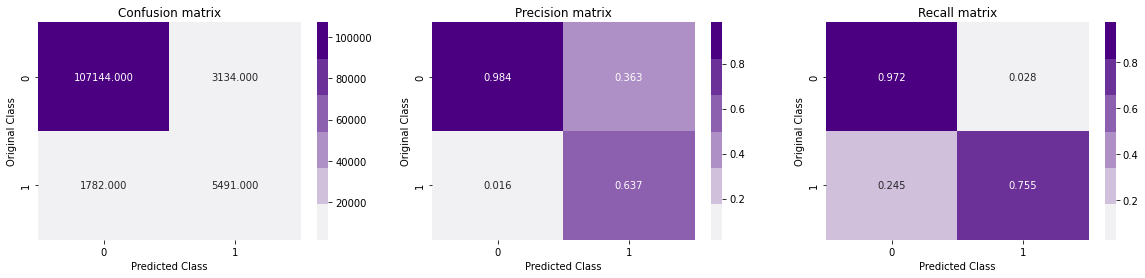

In [ ]:
plot_confusion_matrix(y_test, y_pred_test)

In [ ]:
# check model predictions on wrong classification
wrong_pred_ind = []
for ind in range(len(y_test)):
  if y_pred_test[ind] != y_test.values[ind]:
    wrong_pred_ind.append(ind)

wrong_pred_ind = np.array(wrong_pred_ind)

for ind in np.random.choice(wrong_pred_ind,20):
  
  print('\n')

  print('True value:',y_test.values[ind],',Predicted value:',y_pred_test[ind])
  print('QUESTION:',X_test['question'].iloc[ind])
  

4901


True value: 1 ,Predicted value: 0
QUESTION: how does a tony awards presenter getting a standing ovation for saying f k trump advance the cause of liberalism


True value: 0 ,Predicted value: 1
QUESTION: has the us population realised that the best school in the world is perhaps on the other side of the atlantic sea and no longer harvard


True value: 1 ,Predicted value: 0
QUESTION: how do i deal with a feminist teacher


True value: 1 ,Predicted value: 0
QUESTION: why do the alleged top most genius professional mathematicians usually take centuries to understand so many elementary matters in their own fields


True value: 1 ,Predicted value: 0
QUESTION: if women have sex during periods cause it pregnancy


True value: 1 ,Predicted value: 0
QUESTION: why do dentists like to kill wild animals


True value: 1 ,Predicted value: 0
QUESTION: did donald trump do parkland


True value: 0 ,Predicted value: 1
QUESTION: why do christians and muslims engage in conflicts about religion and r


- There are some data points that were mislabeled, but the model appears to be performing well on the milabeled data. For example model predicted correct labels for the below milabeled datapoints,

>True value: 0 ,Predicted value: 1

> **QUESTION: why exactly are we the us favoring immigration from less educated more violent and poorer countries instead of countries like norway or japan**


> **QUESTION: do trans people ever kill themselves for reasons unrelated to their transness**


----------------

- Model seems to have trouble recognizing insincere questions related to a particular individual or a crisis. For example consider the below examples,


> **QUESTION: did donald trump do parkland**

> True value: 1 ,Predicted value: 0

> **QUESTION: should david hogg and emma gonzales be immediately appointed to the supreme court**

> True value: 1 ,Predicted value: 0


- From the above examples we can see that model is unable to recognize insincerity when questions are targeted towards an individual or a crisis, which is sensible because model doesn't have any prior knowledge of the individual or crisis.
------------------------------------------------------

- There are also some insincere questions where model was unable to capture the context of the question,


> True value: 1 ,Predicted value: 0

> **QUESTION: how do you feel about people getting abortions because the child is going to be intersex or queer**

> True value: 1 ,Predicted value: 0

> **QUESTION: if america was not a country of freedom consistent with its constitutional rights why would it even try to defend freedom in the world**

- The above example are clearly insincere but the model was unable to predict these questions

--------

### Error Analysis

In [ ]:
'''np.save('test_predictions',test_preds)
X_test.to_csv('test_split.csv')
np.save('y_true',y_test.values)'''

test_preds = np.load('test_predictions.npy')
X_test = pd.read_csv('test_split.csv')
y_test = np.load('y_true.npy')

test_y = np.array(y_test,dtype=np.float32)

y_pred_test = [1 if pred > 0.34 else 0 for pred in test_preds]
predictions_test = np.array(y_pred_test,dtype=np.float32)

In [ ]:
# calculate the loss on each datapoint

losses = []

for actual,pred in zip(test_y,test_preds):

  loss = tf.keras.backend.binary_crossentropy(actual,pred)
  losses.append(loss.numpy()[0])

losses = np.array(losses)

wrong_pred_ind = []
for ind in range(len(y_test)):
  if y_pred_test[ind] != y_test[ind]:
    wrong_pred_ind.append(ind)

correct_pred_ind = []
for ind in range(len(y_test)):
  if y_pred_test[ind] == y_test[ind]:
    correct_pred_ind.append(ind)

print(len(wrong_pred_ind))
print(len(correct_pred_ind))

wrong_pred_ind = np.array(wrong_pred_ind)
correct_pred_ind = np.array(correct_pred_ind)

4991
112560


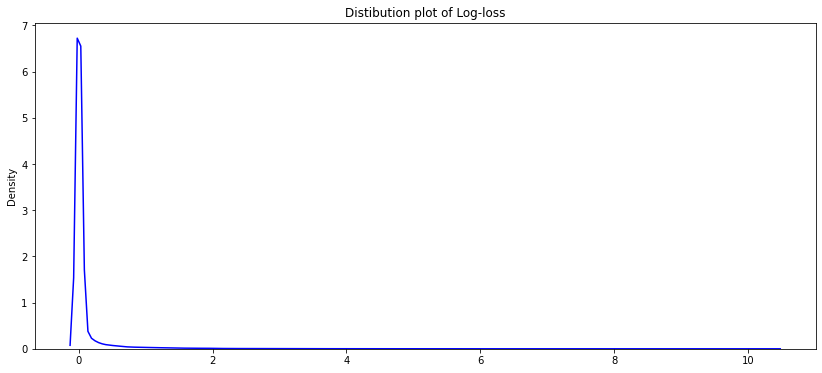

In [ ]:
plt.figure(figsize=(14,6))
sns.kdeplot(losses,color = 'blue')
plt.title('Distibution plot of Log-loss')
plt.show()

In [ ]:
print('Percentile values of losses:')
print('-'*50)
for i in range(0,110,10):
  print(i,'%le:',np.round(np.percentile(losses,i),4))

Percentile values of losses:
--------------------------------------------------
0 %le: 0.0
10 %le: 0.0
20 %le: 0.0001
30 %le: 0.0002
40 %le: 0.0005
50 %le: 0.0009
60 %le: 0.0018
70 %le: 0.0043
80 %le: 0.0156
90 %le: 0.1423
100 %le: 10.3518


In [ ]:
best_loss = 0.0043
avgLoss_start = 0.015
avgLoss_end = 1
worst_loss = 1.0

In [ ]:
bestLoss_questions = X_test.iloc[np.where(losses<=best_loss)]['question'].head(30).values
true_y = y_test[np.where(losses<=best_loss)]
pred_y = predictions_test[np.where(losses<=best_loss)]

print('There are',sum(true_y),'insincere questions when loss is less than',best_loss)
print('\n')

count_correctLabels = sum([1 if true != pred else 0 for true,pred in zip(true_y,pred_y)])
print('Among',len(true_y),'question with loss less than',best_loss,'there are \'',count_correctLabels,'\' no.of questions that were mislabeled.')
print('\n')

print('Questions with least loss:'.upper())

for question,actual,prediction in zip(bestLoss_questions,true_y[:30],pred_y[:30]):

  print('-'*50)
  print('\n')
  print('actual label:',actual,'\t predicted label:',int(prediction))
  print('\n')
  print(question)
  print('\n')
  #print('-'*75)

There are 3 insincere questions when loss is less than 0.0043


Among 82259 question with loss less than 0.0043 there are ' 0 ' no.of questions that were mislabeled.


QUESTIONS WITH LEAST LOSS:
--------------------------------------------------


actual label: 0 	 predicted label: 0


why infinity plays important role in mathematics


--------------------------------------------------


actual label: 0 	 predicted label: 0


what is your favourite blockchain project and why


--------------------------------------------------


actual label: 0 	 predicted label: 0


with two steerable webcams a computer and a two metre rule could i determine the distance of objects within a couple of kilometres


--------------------------------------------------


actual label: 0 	 predicted label: 0


is there any lip lock scene in the harry potter series between ginevra weasley and lord voldemort


--------------------------------------------------


actual label: 0 	 predicted label: 0


cover des

- All the questions with loss less than 0.0043 are sincere questions, there are only 3 insincere questions with loss less than equal to 0.0043.

- No question was misclassified when the loss is 0.0043

- This seems reasonalble due the large amount of data that we have for sincere questions and small amount of data for insincere questions.


In [ ]:
avgLoss_questions = X_test.iloc[np.where((losses>=avgLoss_start)&(losses<=avgLoss_end))]['question'].head(30).values
true_y = y_test[np.where((losses>=avgLoss_start)&(losses<=avgLoss_end))]
pred_y = predictions_test[np.where((losses>=avgLoss_start)&(losses<=avgLoss_end))]
print('There are',sum(true_y),'insincere questions when loss is greater than',avgLoss_start,'and less than',avgLoss_end)
print('\n')

count_correctLabels = sum([1 if true != pred else 0 for true,pred in zip(true_y,pred_y)])
print('Among',len(true_y),'question with loss greater than',avgLoss_start,'and less than',avgLoss_end,'there are \'',count_correctLabels,'\' no.of questions that were mislabeled.')
print('\n')

print('Questions with avg loss:'.upper())

for question,actual,prediction in zip(avgLoss_questions,true_y[:30],pred_y[:30]):
  print('-'*50)
  print('\n')
  print('actual label:',actual,'\t predicted label:',int(prediction))
  print('\n')
  print(question)
  print('\n')
  #print('-'*75)

There are 5164 insincere questions when loss is greater than 0.015 and less than 1


Among 20467 question with loss greater than 0.015 and less than 1 there are ' 1779 ' no.of questions that were mislabeled.


QUESTIONS WITH AVG LOSS:
--------------------------------------------------


actual label: 0 	 predicted label: 0


what is pakistan getting by protecting hafiz saeed


--------------------------------------------------


actual label: 0 	 predicted label: 0


how common is it for jewish men and palestinian women to date


--------------------------------------------------


actual label: 0 	 predicted label: 0


was it right for me to miss my prom


--------------------------------------------------


actual label: 0 	 predicted label: 0


will the second amendment ever be abolished


--------------------------------------------------


actual label: 1 	 predicted label: 1


why in the fuck would anyone vote for that fucking cunt


----------------------------------------------

- There are 20467 questions with loss between 0.0156 and 1 and 5164 among them are insincere questoins.

- If we observe the questions with loss between 0.015 and 1, there are queit a few no.of questions that are mislabeled, questions are mostly mislabeled as sincere questions while they actually belong to insncere category.

- Model also predicted these mislabeled insincere questions as sincere questions, this could be a reason for recall and precision not improving to a better value. Model was able to predict few mislabeled questions to their true class.

In [ ]:
worstLoss_questions = X_test.iloc[np.where(losses>=worst_loss)]['question'].head(30).values
true_y = y_test[np.where(losses>=worst_loss)]
pred_y = predictions_test[np.where(losses>=worst_loss)]
print('There are',sum(true_y),'insincere questions when loss is greater than',worst_loss)
print('\n')

count_correctLabels = sum([1 if true != pred else 0 for true,pred in zip(true_y,pred_y)])
print('Among',len(true_y),'question with loss greater than',worst_loss,'there are \'',count_correctLabels,'\' no.of questions that were mislabeled.')
print('\n')

print('Questions with high loss:'.upper())

for question,actual,prediction in zip(bestLoss_questions,true_y[:30],pred_y[:30]):

  print('-'*50)
  print('\n')
  print('actual label:',actual,'\t predicted label:',int(prediction))
  print('\n')
  print(question)
  print('\n')
  #print('-'*75)
  7273

There are 2078 insincere questions when loss is greater than 1.0


Among 3333 question with loss greater than 1.0 there are ' 3212 ' no.of questions that were mislabeled.


QUESTIONS WITH HIGH LOSS:
--------------------------------------------------


actual label: 1 	 predicted label: 0


why infinity plays important role in mathematics


--------------------------------------------------


actual label: 1 	 predicted label: 0


what is your favourite blockchain project and why


--------------------------------------------------


actual label: 0 	 predicted label: 1


with two steerable webcams a computer and a two metre rule could i determine the distance of objects within a couple of kilometres


--------------------------------------------------


actual label: 0 	 predicted label: 1


is there any lip lock scene in the harry potter series between ginevra weasley and lord voldemort


--------------------------------------------------


actual label: 1 	 predicted label: 0


cover

- There are 3333 questions that have loss greater than 1, almost all the questions that have loss greater than 1 are misclassified by the model.

- Most of the questions that were misclassified are actually mislabeled, model seems to uderstand the semantics of the data because for most cases model is actually prediting correct class labels for mislabeled data, but mislabeling is a problem for the data.

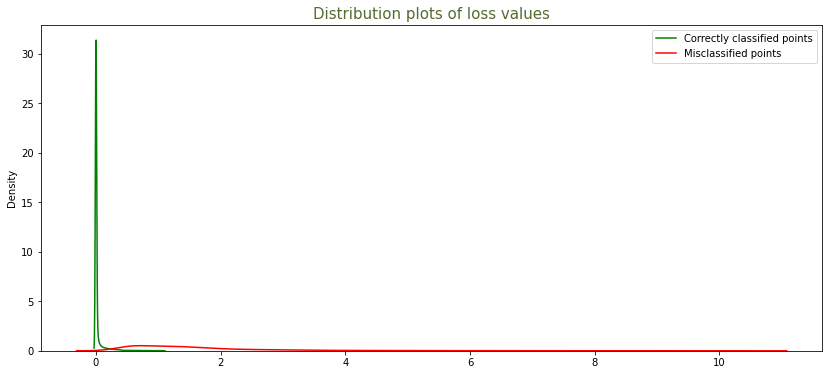

In [ ]:
misclassified_quesLoss = losses[wrong_pred_ind]
correctpredicted_quesLoss = losses[correct_pred_ind]

plt.figure(figsize=(14,6))

#plt.subplot(1,2,1)
sns.kdeplot(correctpredicted_quesLoss,color = 'green',label = 'Correctly classified points')
#plt.legend()

#plt.subplot(1,2,2)
sns.kdeplot(misclassified_quesLoss,color = 'red',label = 'Misclassified points')

plt.legend()
plt.title('Distribution plots of loss values',color = 'darkolivegreen',fontsize=15)
plt.show()

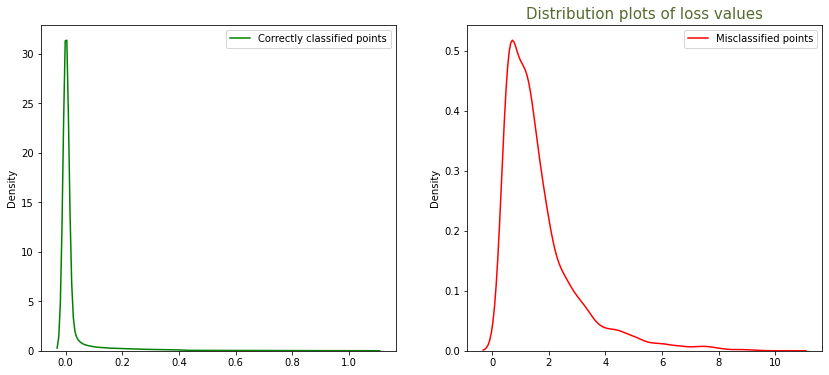

In [ ]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.kdeplot(correctpredicted_quesLoss,color = 'green',label = 'Correctly classified points')
plt.legend()

plt.subplot(1,2,2)
sns.kdeplot(misclassified_quesLoss,color = 'red',label = 'Misclassified points')

plt.legend()
plt.title('Distribution plots of loss values',color = 'darkolivegreen',fontsize=15)
plt.show()

In [ ]:
print('-'*50)
print('|Percentile values of correctly classified points:|')
print('-'*50)
for i in range(0,110,10):
  print('\t',i,'%le:','\t',np.round(np.percentile(correctpredicted_quesLoss,i),4))

print('\n')

print('-'*46)
print('|Percentile values of Misclassified points:|')
print('-'*46)
for i in range(0,110,10):
  print('\t',i,'%le:','\t',np.round(np.percentile(misclassified_quesLoss,i),4))

--------------------------------------------------
|Percentile values of correctly classified points:|
--------------------------------------------------
	 0 %le: 	 0.0
	 10 %le: 	 0.0
	 20 %le: 	 0.0001
	 30 %le: 	 0.0002
	 40 %le: 	 0.0004
	 50 %le: 	 0.0008
	 60 %le: 	 0.0015
	 70 %le: 	 0.0032
	 80 %le: 	 0.0094
	 90 %le: 	 0.0536
	 100 %le: 	 1.0785


----------------------------------------------
|Percentile values of Misclassified points:|
----------------------------------------------
	 0 %le: 	 0.4158
	 10 %le: 	 0.5245
	 20 %le: 	 0.6553
	 30 %le: 	 0.861
	 40 %le: 	 1.1035
	 50 %le: 	 1.2778
	 60 %le: 	 1.5064
	 70 %le: 	 1.8399
	 80 %le: 	 2.3663
	 90 %le: 	 3.3146
	 100 %le: 	 10.3518


In [ ]:
for i in range(90,101):
  print('\t',i,'%le:','\t',np.round(np.percentile(correctpredicted_quesLoss,i),4))

	 90 %le: 	 0.0536
	 91 %le: 	 0.0682
	 92 %le: 	 0.0878
	 93 %le: 	 0.112
	 94 %le: 	 0.1427
	 95 %le: 	 0.1799
	 96 %le: 	 0.2252
	 97 %le: 	 0.2862
	 98 %le: 	 0.3688
	 99 %le: 	 0.5588
	 100 %le: 	 1.0785


- As we can see from the distribution plots of the losses of misclassified points and correctly classified points there is small overlap between the distributions. 

- All the misclassified points have a loss greater than 0.41 while only 2% of correctly classified data has loss greater than 0.41

In [ ]:
best_loss = 1.0

misclassified_minLoss = X_test.iloc[wrong_pred_ind[np.where(misclassified_quesLoss<1)]]['question'].head(30).values
true_y = y_test[wrong_pred_ind[np.where(misclassified_quesLoss<1)]]
pred_y = predictions_test[wrong_pred_ind[np.where(misclassified_quesLoss<1)]]

print('Misclassified questions with least loss:'.upper())
print('\n')

for question,actual,prediction in zip(misclassified_minLoss,true_y[:30],pred_y[:30]):

  print('-'*50)
  print('\n')
  print('actual label:',actual,'\t predicted label:',int(prediction))
  print('\n')
  print(question)
  print('\n')
  #print('-'*75)

MISCLASSIFIED QUESTIONS WITH LEAST LOSS:


--------------------------------------------------


actual label: 0 	 predicted label: 1


is canada willing to open up and take the refugees and immigrants that the us and uk will not now if not why not


--------------------------------------------------


actual label: 0 	 predicted label: 1


there are caste systems in india and many people believing that one own character can be judged based on one own caste do you think it is a good idea to add caste as a to be filled field in an application form is it not unprofessional


--------------------------------------------------


actual label: 0 	 predicted label: 1


why do people ignore obvious facts in opposition to gun control what is with the sensational hate for guns


--------------------------------------------------


actual label: 0 	 predicted label: 1


do girls deserve reservation in iits


--------------------------------------------------


actual label: 0 	 predicted label: 1

- The misclassified questions with least logloss(<1.0) have all labels predicted as 1. These questions are indeed insincere but were mislabeled as sincere, all these questions have been correctly identified by the model as insincere.

- It appears that mislabeled insincere questions has least loss values among the misclassifieds.


In [ ]:
misclassified_que_minLoss = X_test.iloc[wrong_pred_ind[np.where((misclassified_quesLoss> 1) & (misclassified_quesLoss < 2))]]['question'].head(30).values
true_y = y_test[wrong_pred_ind[np.where((misclassified_quesLoss > 1) & (misclassified_quesLoss < 2))]]
pred_y = predictions_test[wrong_pred_ind[np.where((misclassified_quesLoss > 1) & (misclassified_quesLoss < 2))]]

print('Misclassified questions with moderate loss:'.upper())
print('\n')

for question,actual,prediction in zip(misclassified_que_minLoss,true_y[:30],pred_y[:30]):
  print('-'*50)
  print('\n')
  print('actual label:',actual,'\t predicted label:',int(prediction))
  print('\n')
  print(question)
  print('\n')

MISCLASSIFIED QUESTIONS WITH MODERATE LOSS:


--------------------------------------------------


actual label: 1 	 predicted label: 0


quora is an indian oriented website should i delete my account


--------------------------------------------------


actual label: 1 	 predicted label: 0


since humans hunt and eat primates is eating primates considered cannibalism


--------------------------------------------------


actual label: 0 	 predicted label: 1


why are many actors in fiction movies especially space related shown with weird features like one eye half open head walking disabled like burn like skin sores does not that concept go against evolution as we know it what is being conveyed


--------------------------------------------------


actual label: 0 	 predicted label: 1


why are democrats outraged about the possibility of russian interference of elections but passively accept it when democratic leaders do it


--------------------------------------------------


actua

- Again mislabeled data appears to be a problem when observed the questions with moderate loss, there are many questons that were mislabeled and model seems to be classifiying them correctly.

- There are some questions where model is predicting them wrongly as sincere while they are actually insincere, model was unable to capture the insncerity for few questions.

In [ ]:
misclassified_que_minLoss = X_test.iloc[wrong_pred_ind[np.where(misclassified_quesLoss>2)]]['question'].head(100).values
true_y = y_test[wrong_pred_ind[np.where(misclassified_quesLoss>2)]]
pred_y = predictions_test[wrong_pred_ind[np.where(misclassified_quesLoss>2)]]

print('Misclassified questions with high loss:'.upper())
print('\n')

for question,actual,prediction in zip(misclassified_que_minLoss,true_y[:100],pred_y[:100]):
  print('-'*50)
  print('\n')
  print('actual label:',actual,'\t predicted label:',int(prediction))
  print('\n')
  print(question)
  print('\n')

MISCLASSIFIED QUESTIONS WITH HIGH LOSS:


--------------------------------------------------


actual label: 1 	 predicted label: 0


has not god outlawed spoiling the neighbour including any tax usury inflation or speculation


--------------------------------------------------


actual label: 1 	 predicted label: 0


why is swiggy such a fraud service the prices are marked up over the actual prices average delivery time is more than hours for a distance of kms even if you this distance you will not take more than mins


--------------------------------------------------


actual label: 1 	 predicted label: 0


i told her you are ugly just like your mom she started crying why did she cry when i told her the truth i mean did not lie


--------------------------------------------------


actual label: 1 	 predicted label: 0


who would win in a fight king kong or stay puft marshmallow man


--------------------------------------------------


actual label: 1 	 predicted label: 0


are t

- Most of the questions with losses grater than 2.0 are labeled as sincere, data mislabeling issue can be observed even for the loss greater than 2. 

- Model is miclassifying insincere questions as sincere,this could be because of the mislabeled data because if we observe the misclassified questions with loss less than 1 all of them are misclassified as sincere while they were actually insincere, even though model was able to predict them as insincere model appears to get confused between sincere and insincere questions because of mislabeling.

- Molde performance might have been much better if there are no mislabeld data